In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# nearest neighbor interpolation
def NNI(img, scale):
    h, w = img.shape
    new_h, new_w = int(h * scale), int(w * scale)
    out = np.zeros((new_h, new_w), dtype=img.dtype)

    for i in range(new_h):
        for j in range(new_w):
            x = round(i / scale)
            y = round(j / scale)
            x = min(x, h - 1)
            y = min(y, w - 1)
            out[i, j] = img[x, y]
    return out

# bilinear interpolation
def BLI(img, scale):
    h, w = img.shape
    new_h, new_w = int(h * scale), int(w * scale)
    out = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            x = i / scale
            y = j / scale

            x0 = int(np.floor(x))
            x1 = min(x0 + 1, h - 1)
            y0 = int(np.floor(y))
            y1 = min(y0 + 1, w - 1)

            dx = x - x0
            dy = y - y0

            # 四個鄰近點
            I00 = img[x0, y0]
            I01 = img[x0, y1]
            I10 = img[x1, y0]
            I11 = img[x1, y1]

            # 雙線性公式
            out[i, j] = (1 - dx) * (1 - dy) * I00 + (1 - dx) * dy * I01 + dx * (1 - dy) * I10 + dx * dy * I11

    return np.clip(out, 0, 255).astype(img.dtype)

# bicubic interpolation
def cubic_weight(t):
    a = -0.5  # Catmull-Rom spline
    t = abs(t)
    if t <= 1:
        return (a + 2)*t**3 - (a + 3)*t**2 + 1
    elif t < 2:
        return a*t**3 - 5*a*t**2 + 8*a*t - 4*a
    else:
        return 0
        
def BCI(img, scale):
    h, w = img.shape
    new_h, new_w = int(h * scale), int(w * scale)
    out = np.zeros((new_h, new_w), dtype=np.float32)

    for i in range(new_h):
        for j in range(new_w):
            x = i / scale
            y = j / scale

            x0 = int(np.floor(x))
            y0 = int(np.floor(y))

            value = 0.0
            for m in range(-1, 3):
                for n in range(-1, 3):
                    xm = min(max(x0 + m, 0), h - 1)
                    yn = min(max(y0 + n, 0), w - 1)

                    wx = cubic_weight(x - (x0 + m))
                    wy = cubic_weight(y - (y0 + n))

                    value += img[xm, yn] * wx * wy

            out[i, j] = value

    return np.clip(out, 0, 255).astype(img.dtype)


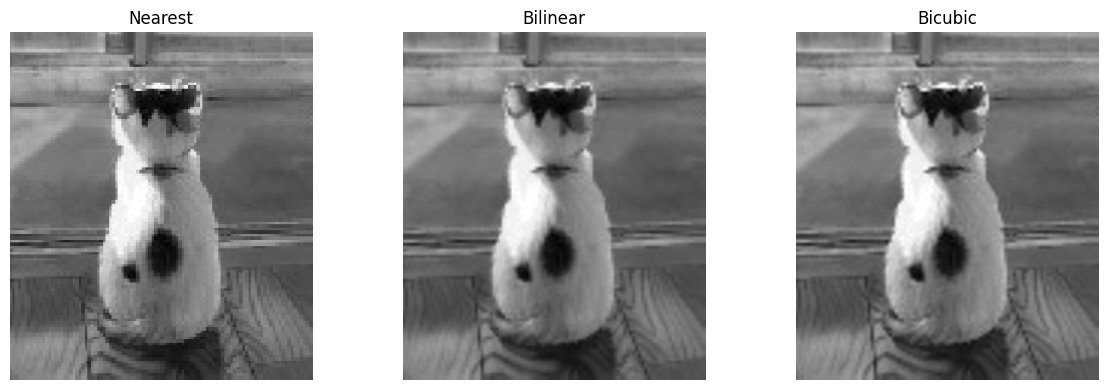

In [5]:
img1 = cv2.imread('cat.jpeg', cv2.IMREAD_GRAYSCALE)
scale = 4

nni_img = NNI(img1, scale)
bli_img = BLI(img1, scale)
bci_img = BCI(img1, scale)

plt.figure(figsize=(12, 4))
for i, (title, image) in enumerate(zip(['Nearest', 'Bilinear', 'Bicubic'], [nni_img, bli_img, bci_img])):
    plt.subplot(1, 3, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.show()


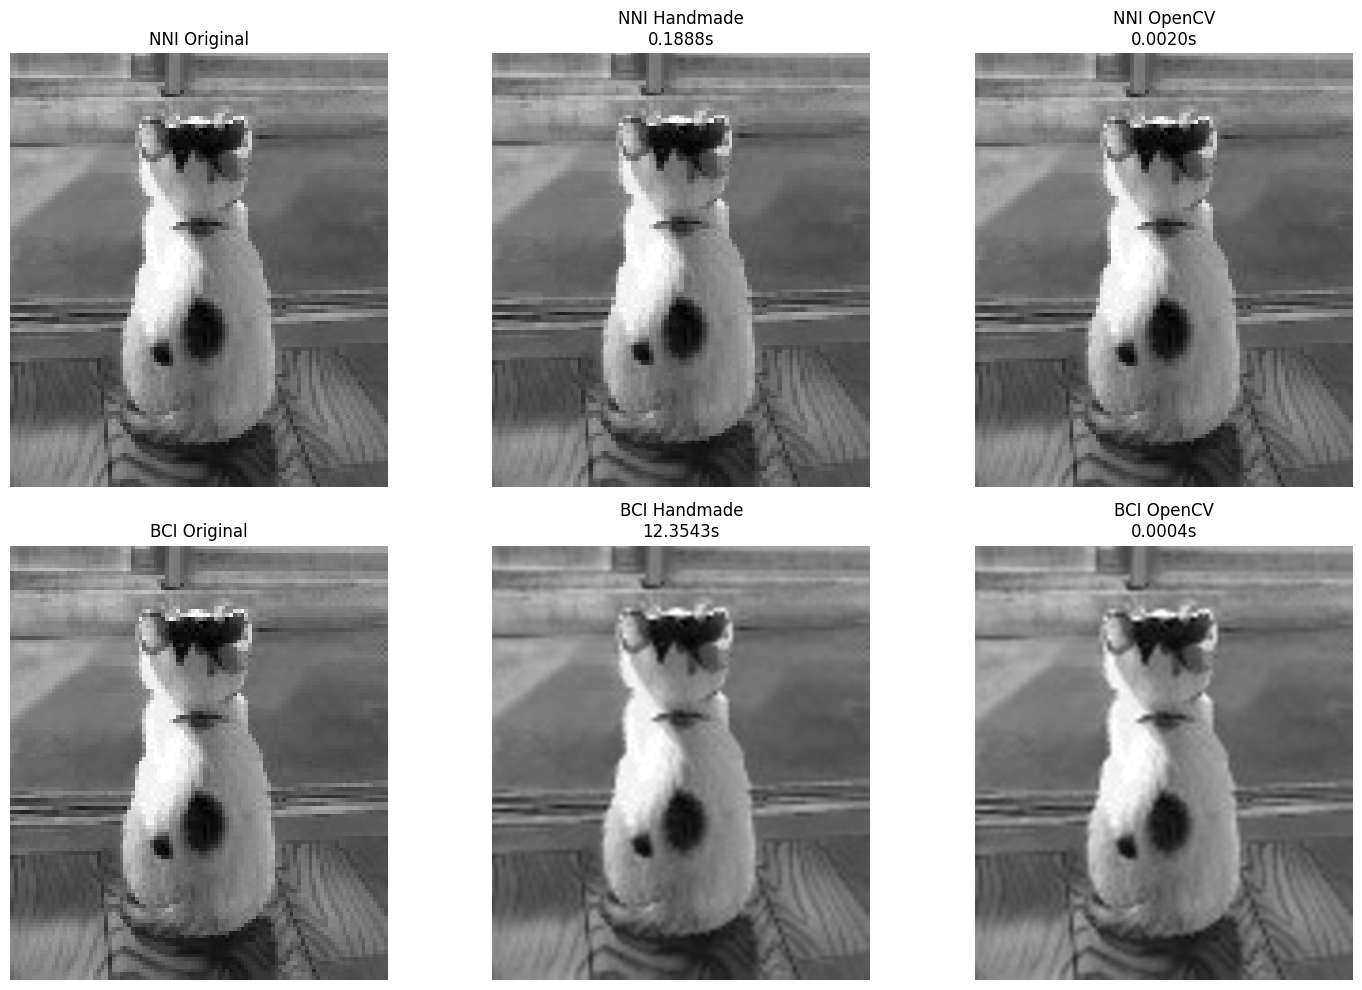

In [7]:
img = cv2.imread('cat.jpeg', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('wall.jpeg', cv2.IMREAD_GRAYSCALE)
scale = 4
new_size = (int(img.shape[1] * scale), int(img.shape[0] * scale))

use_nni = True
use_bli = False
use_bci = True

images = []
titles = []

def add_group(name, handmade_img, handmade_time, opencv_img, opencv_time):
    titles.extend([
        f"{name} Original",
        f"{name} Handmade\n{handmade_time:.4f}s",
        f"{name} OpenCV\n{opencv_time:.4f}s"
    ])
    images.extend([img1, handmade_img, opencv_img])

if use_nni:
    start = time.time()
    nni_img = NNI(img1, scale)
    t_nni = time.time() - start

    start = time.time()
    nearest = cv2.resize(img1, new_size, interpolation=cv2.INTER_NEAREST)
    t_nearest = time.time() - start

    add_group("NNI", nni_img, t_nni, nearest, t_nearest)
    
if use_bli:    
    start = time.time()
    bli_img = BLI(img1, scale)
    t_bli = time.time() - start

    start = time.time()
    bilinear = cv2.resize(img1, new_size, interpolation=cv2.INTER_LINEAR)
    t_bilinear = time.time() - start

    add_group("BLI", bli_img, t_bli, bilinear, t_bilinear)

if use_bci:
    start = time.time()
    bci_img = BCI(img1, scale)
    t_bci = time.time() - start

    start = time.time()
    bicubic = cv2.resize(img1, new_size, interpolation=cv2.INTER_CUBIC)
    t_bicubic = time.time() - start

    add_group("BCI", bci_img, t_bci, bicubic, t_bicubic)

# plot
rows = len(images) // 3
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = np.array(axes).reshape(rows, 3)

for i, (img, title) in enumerate(zip(images, titles)):
    r, c = divmod(i, 3)
    axes[r, c].imshow(img, cmap='gray')
    axes[r, c].set_title(title)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()